# Count data processing

See `data/count/readme.md` for a detailed description of the count data. This script combine the historical data until 2021 `data/count_2021.xlsx` and merge with the raw Trektellen files since 2021 `data/raw_count/Trektellen_data_2422_{y}.xlsx` to produce the file `all_count_processed.csv` which is used in the model.


In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pytz

local_tz = pytz.timezone("Europe/Paris")

## Old data

Formatted manually


In [12]:
do = pd.concat(
    [
        pd.read_excel("../data/count/count_2021.xlsx", sheet_name="1966-2013"),
        pd.read_excel("../data/count/count_2021.xlsx", sheet_name="2014-2016"),
        pd.read_excel("../data/count/count_2021.xlsx", sheet_name="2017-2021"),
    ]
)

# Compute start and end
do["startTime"] = pd.to_datetime(do["startTime"], format="%H:%M:%S").dt.time
do["start"] = do["date"] + pd.to_timedelta(do["startTime"].astype(str))
do["endTime"] = pd.to_datetime(do["endTime"], format="%H:%M:%S").dt.time
do["end"] = do["date"] + pd.to_timedelta(do["endTime"].astype(str))

# Compute day and end
do["startTimeDay"] = pd.to_datetime(do["startTimeDay"], format="%H:%M:%S").dt.time
do["startDay"] = do["date"] + pd.to_timedelta(do["startTimeDay"].astype(str))
do["endTimeDay"] = pd.to_datetime(do["endTimeDay"], format="%H:%M:%S").dt.time
do["endDay"] = do["date"] + pd.to_timedelta(do["endTimeDay"].astype(str))
do["startDay"] = do["startDay"].fillna(do["start"])
do["endDay"] = do["endDay"].fillna(do["end"])

#
do["start"] = do["start"].dt.tz_localize(local_tz, ambiguous="NaT").dt.tz_convert("UTC")
do["end"] = do["end"].dt.tz_localize(local_tz, ambiguous="NaT").dt.tz_convert("UTC")
do["startDay"] = (
    do["startDay"].dt.tz_localize(local_tz, ambiguous="NaT").dt.tz_convert("UTC")
)
do["endDay"] = (
    do["endDay"].dt.tz_localize(local_tz, ambiguous="NaT").dt.tz_convert("UTC")
)

# Keep only relevant column
do = do[["species", "date", "count", "start", "end", "startDay", "endDay"]]

# Sum count of same species-time interval
do = (
    (
        do.groupby(["species", "date", "start", "end", "startDay", "endDay"])
        .agg({"count": "sum"})
        .reset_index()
    )
    .sort_values("date")
    .reset_index(drop=True)
)

In [13]:
print(do[do.start >= do.end])
print(do[do.start < do.startDay])
print(do[do.end > do.endDay])

Empty DataFrame
Columns: [species, date, start, end, startDay, endDay, count]
Index: []
Empty DataFrame
Columns: [species, date, start, end, startDay, endDay, count]
Index: []
Empty DataFrame
Columns: [species, date, start, end, startDay, endDay, count]
Index: []


In [14]:
period_recorded = (
    do.groupby(["date", "start", "end", "startDay", "endDay"])
    .size()
    .reset_index(name="Count")
    .reset_index()
).sort_values("start")

period_recorded["period_duration"] = period_recorded["end"] - period_recorded["start"]

period_recorded["period_in_day"] = period_recorded.groupby("date")["start"].transform(
    lambda x: x.nunique()
)

In [15]:
# Check for no overlap
# Check overlap between periods
def is_overlapping(row, df, start="start", end="end"):
    # Exclude the row itself by comparing indices
    mask = df.index != row.name
    return ((df.loc[mask, start] < row[end]) & (df.loc[mask, end] > row[start])).any()


# Filter the DataFrame for overlapping periods
period_recorded[period_recorded.apply(is_overlapping, axis=1, df=period_recorded)]

,index,date,start,end,startDay,endDay,Count,period_duration,period_in_day


In [16]:
period_to_expand = period_recorded[
    (period_recorded["start"] != period_recorded["startDay"])
    & (period_recorded["end"] != period_recorded["endDay"])
    & (
        (period_recorded["endDay"] - period_recorded["startDay"])
        > pd.Timedelta(hours=2)
    )
]
period_to_expand = (
    period_to_expand[["startDay", "endDay", "date"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [17]:
def period2do(df):
    rows = []
    for _, row in df.iterrows():
        # Generate hourly range, starting from the next full hour after start
        hourly_range = pd.date_range(row["startDay"].ceil("h"), row["endDay"], freq="h")

        # Include exact start
        row["start"] = (row["startDay"],)
        row["end"] = (row["startDay"].ceil("h"),)
        rows.append(row)

        # Add hourly periods between start and end periods
        for hour in hourly_range:
            row["start"] = hour
            row["end"] = hour + pd.Timedelta(hours=1)
            if row["end"] > row["endDay"]:
                row["end"] = row["endDay"]
            rows.append(row)

    expend = pd.DataFrame(rows).drop_duplicates().reset_index(drop=True)

    expend["species"] = "Aucune espèce"  # No species/aucune espèce
    expend["count"] = 0
    return expend


# Expand the dataframe
do_no_species = period2do(period_to_expand)

In [18]:
do_expended = (
    pd.concat(
        [do, do_no_species],
        axis=0,
    )
    .sort_values(by="start")
    .reset_index(drop=True)
)

In [19]:
dot = pd.merge(
    do_expended,
    pd.read_csv(f"../data/taxonomy.csv")[["species", "English name"]],
    how="left",
    on="species",
)
dot["species"] = dot["English name"]

In [20]:
dot

,species,date,start,end,startDay,endDay,count,English name
0,Peregrine Falcon,1966-09-11,1966-09-11 05:40:00+00:00,1966-09-11 11:25:00+00:00,1966-09-11 05:40:00+00:00,1966-09-11 11:25:00+00:00,1,Peregrine Falcon
1,Montagu's Harrier,1966-09-11,1966-09-11 05:40:00+00:00,1966-09-11 11:25:00+00:00,1966-09-11 05:40:00+00:00,1966-09-11 11:25:00+00:00,1,Montagu's Harrier
2,Eurasian Sparrowhawk,1966-09-11,1966-09-11 05:40:00+00:00,1966-09-11 11:25:00+00:00,1966-09-11 05:40:00+00:00,1966-09-11 11:25:00+00:00,1,Eurasian Sparrowhawk
3,European Honey-buzzard,1966-09-11,1966-09-11 05:40:00+00:00,1966-09-11 11:25:00+00:00,1966-09-11 05:40:00+00:00,1966-09-11 11:25:00+00:00,87,European Honey-buzzard
4,Stock Dove,1966-09-11,1966-09-11 05:40:00+00:00,1966-09-11 11:25:00+00:00,1966-09-11 05:40:00+00:00,1966-09-11 11:25:00+00:00,7,Stock Dove
...,...,...,...,...,...,...,...,...
80161,Red Kite,2021-11-29,2021-11-29 13:00:00+00:00,2021-11-29 13:15:00+00:00,2021-11-29 10:00:00+00:00,2021-11-29 13:15:00+00:00,1,Red Kite
80162,Common Buzzard,2021-12-03,2021-12-03 10:40:00+00:00,2021-12-03 12:40:00+00:00,2021-12-03 10:40:00+00:00,2021-12-03 12:40:00+00:00,24,Common Buzzard
80163,Red Kite,2021-12-03,2021-12-03 10:40:00+00:00,2021-12-03 12:40:00+00:00,2021-12-03 10:40:00+00:00,2021-12-03 12:40:00+00:00,31,Red Kite
80164,Red Kite,2021-12-18,2021-12-18 13:00:00+00:00,2021-12-18 14:30:00+00:00,2021-12-18 13:00:00+00:00,2021-12-18 14:30:00+00:00,12,Red Kite


## Trektellen data

This data is exported from website every year.

`headerdata` contains the information of the `count_id` periods of count which can be any duration. Sometimes they have recorded each hours in a different period, other time a single period for the full day (but with datetime for each sightings). And sometimes just two periods???

We actually want the hourly count and thus split the periods in 1hr duration whenever we can. 




Read all file and merge into a single file.


In [21]:
dn = []
for y in range(2022, 2024):
    dnn = pd.merge(
        pd.read_excel(f"../data/count/raw_count/Trektellen_data_2422_{y}.xlsx"),
        pd.read_excel(f"../data/count/raw_count/Trektellen_headerdata_2422_{y}.xlsx"),
        left_on="countid",
        right_on="id",
    )
    dn.append(dnn)
dn = pd.concat(dn, ignore_index=True)


# Convert the 'start' column to local timezone, then to UTC

dn["start"] = (
    pd.to_datetime(dn["start"])
    .dt.tz_localize(local_tz, ambiguous="NaT")
    .dt.tz_convert("UTC")
)
dn["end"] = (
    pd.to_datetime(dn["stop"])
    .dt.tz_localize(local_tz, ambiguous="NaT")
    .dt.tz_convert("UTC")
)
dn["datetime"] = (
    pd.to_datetime(dn["date"] + " " + dn["timestamp"])
    .dt.tz_localize(local_tz, ambiguous="NaT")
    .dt.tz_convert("UTC")
)
dn["date"] = pd.to_datetime(dn["date"])

dn["count"] = dn["direction1"]  # + dn["direction2"]
dn["period_id"] = dn["id"]

dn = dn[["period_id", "datetime", "date", "start", "end", "speciesid", "count"]]

Fix issue with datetime before start or after end

1. correct timing within 10 minute of start and end.
2. Ignore others.


In [22]:
# Entry which have a datetime before start, but only 10 minutes before
id = (dn["datetime"] < dn["start"]) & (
    abs(dn["datetime"] - dn["start"]) < pd.Timedelta(minutes=10)
)
dn.loc[id, "datetime"] = dn.loc[id, "start"] + pd.Timedelta(minutes=1)

# eEntry which have a datetime after end, but only max 10 minutes after
id = (dn["datetime"] >= dn["end"]) & (
    abs(dn["datetime"] - dn["end"]) < pd.Timedelta(minutes=10)
)
dn.loc[id, "datetime"] = dn.loc[id, "end"] - pd.Timedelta(minutes=1)

# Ignore the other data
id = (dn["datetime"] < dn["start"]) | (dn["datetime"] > dn["end"])
print(sum(id))
dn = dn[~id]

22


Build table of period

In [23]:
period_recorded = (
    dn.groupby(["period_id", "date", "start", "end"])
    .agg(
        count_na_datetime=("datetime", lambda x: x.isna().sum()),
        count=("datetime", "size"),
    )
    .reset_index()
)

period_recorded["count_na_datetime_prop"] = (
    period_recorded["count_na_datetime"] / period_recorded["count"]
)

period_recorded["period_duration"] = period_recorded["end"] - period_recorded["start"]

period_recorded["period_in_day"] = period_recorded.groupby("date")["start"].transform(
    lambda x: x.nunique()
)

In [24]:
# Check for no overlap
# Check overlap between periods
def is_overlapping(row, df, start="start", end="end"):
    # Exclude the row itself by comparing indices
    mask = df.index != row.name
    return ((df.loc[mask, start] < row[end]) & (df.loc[mask, end] > row[start])).any()


# Filter the DataFrame for overlapping periods
period_recorded[period_recorded.apply(is_overlapping, axis=1, df=period_recorded)]

,period_id,date,start,end,count_na_datetime,count,count_na_datetime_prop,period_duration,period_in_day


Select period to expend into hourly period by selecting only period lasting at least 2 hours and with mostly data with datetime

In [25]:
period_to_expand = period_recorded[
    (period_recorded["period_duration"] > pd.Timedelta(hours=2))
    & (period_recorded["count_na_datetime_prop"] < 0.5)
]
period_to_expand

,period_id,date,start,end,count_na_datetime,count,count_na_datetime_prop,period_duration,period_in_day
1,2245190,2022-07-19,2022-07-19 07:00:00+00:00,2022-07-19 15:35:00+00:00,0,10,0.000000,0 days 08:35:00,1
2,2245315,2022-07-20,2022-07-20 07:05:00+00:00,2022-07-20 15:30:00+00:00,0,9,0.000000,0 days 08:25:00,1
3,2245515,2022-07-21,2022-07-21 07:00:00+00:00,2022-07-21 15:30:00+00:00,0,27,0.000000,0 days 08:30:00,1
4,2245836,2022-07-22,2022-07-22 07:00:00+00:00,2022-07-22 15:30:00+00:00,2,23,0.086957,0 days 08:30:00,1
5,2246061,2022-07-23,2022-07-23 07:05:00+00:00,2022-07-23 15:30:00+00:00,0,24,0.000000,0 days 08:25:00,1
...,...,...,...,...,...,...,...,...,...
298,2554483,2023-11-19,2023-11-19 06:34:00+00:00,2023-11-19 13:14:00+00:00,0,110,0.000000,0 days 06:40:00,1
299,2557350,2023-11-23,2023-11-23 10:30:00+00:00,2023-11-23 14:50:00+00:00,0,29,0.000000,0 days 04:20:00,1
300,2567813,2023-12-07,2023-12-07 08:45:00+00:00,2023-12-07 14:30:00+00:00,0,110,0.000000,0 days 05:45:00,1
301,2567814,2023-12-06,2023-12-06 08:56:00+00:00,2023-12-06 14:00:00+00:00,0,79,0.000000,0 days 05:04:00,1


Create no species record for every hours to make sure that we have a record for each hours. 

In [26]:
def period2dn(df):
    rows = []
    for _, row in df.iterrows():
        # Generate hourly range, starting from the next full hour after start
        hourly_range = pd.date_range(row["start"].ceil("h"), row["end"], freq="h")

        # Include exact start
        rows.append({**row, "datetime": row["start"]})

        # Add hourly timestamps between start and end periods
        for hour in hourly_range:
            rows.append({**row, "datetime": hour})

        # If end is not exactly on an hour, ensure the exact end is included
        if row["end"] not in hourly_range:
            rows.append({**row, "datetime": row["end"]})

    expend = pd.DataFrame(rows).drop_duplicates().reset_index(drop=True)

    expend["speciesid"] = 480  # No species/aucune espèce
    expend["count"] = 0
    return expend


# Expand the dataframe
dn_no_species = period2dn(period_to_expand[["period_id", "date", "start", "end"]])

In [27]:
dn_expended = (
    pd.concat(
        [dn, dn_no_species],
        axis=0,
    )
    .sort_values(by=["start", "datetime"])
    .reset_index(drop=True)
)

dn_expended

,period_id,datetime,date,start,end,speciesid,count
0,2244952,NaT,2022-07-18,2022-07-18 07:05:00+00:00,2022-07-18 15:35:00+00:00,89,1
1,2244952,NaT,2022-07-18,2022-07-18 07:05:00+00:00,2022-07-18 15:35:00+00:00,249,7
2,2244952,NaT,2022-07-18,2022-07-18 07:05:00+00:00,2022-07-18 15:35:00+00:00,88,11
3,2244952,NaT,2022-07-18,2022-07-18 07:05:00+00:00,2022-07-18 15:35:00+00:00,88,126
4,2245190,2022-07-19 07:00:00+00:00,2022-07-19,2022-07-19 07:00:00+00:00,2022-07-19 15:35:00+00:00,480,0
...,...,...,...,...,...,...,...
40106,2567813,2023-12-07 14:15:00+00:00,2023-12-07,2023-12-07 08:45:00+00:00,2023-12-07 14:30:00+00:00,101,11
40107,2567813,2023-12-07 14:17:02+00:00,2023-12-07,2023-12-07 08:45:00+00:00,2023-12-07 14:30:00+00:00,89,5
40108,2567813,2023-12-07 14:19:03+00:00,2023-12-07,2023-12-07 08:45:00+00:00,2023-12-07 14:30:00+00:00,89,2
40109,2567813,2023-12-07 14:21:38+00:00,2023-12-07,2023-12-07 08:45:00+00:00,2023-12-07 14:30:00+00:00,89,4


Remove record without datetime for a period to expand. Mostly local bird (not migrating) or sometimes added at the end of the day without a precise time (too bad!)

In [28]:
dn_expended_filtered = dn_expended[
    ~(
        (dn_expended["datetime"].isna())
        & dn_expended["period_id"].isin(period_to_expand["period_id"])
    )
]
print(dn_expended.size)
print(dn_expended_filtered.size)

280777
280161


Subdivide period by modifying the start and endperiod of each

In [29]:
def updatePeriod(row):
    if pd.notna(row["datetime"]):
        # compute the floor and ceil
        datetime_floor = row["datetime"].floor("h")
        datetime_ceil = row["datetime"].ceil("h")

        # If datetime falls on the perfect hour, the ceil is actual staying on this number and we want to be on the next hour
        if datetime_ceil == datetime_floor:
            datetime_ceil += pd.Timedelta(hours=1)

        row["start"] = max(datetime_floor, row["start"])
        row["end"] = min(datetime_ceil, row["end"])
    return row


id_row = dn_expended_filtered["period_id"].isin(period_to_expand["period_id"])

dn2 = pd.concat(
    [
        dn_expended_filtered[~id_row],
        dn_expended_filtered[id_row].apply(updatePeriod, axis=1),
    ]
).sort_values(by=["start", "datetime"])

In [30]:
dn2["duration"] = dn2["end"] - dn2["start"]
dn2

,period_id,datetime,date,start,end,speciesid,count,duration
0,2244952,NaT,2022-07-18,2022-07-18 07:05:00+00:00,2022-07-18 15:35:00+00:00,89,1,0 days 08:30:00
1,2244952,NaT,2022-07-18,2022-07-18 07:05:00+00:00,2022-07-18 15:35:00+00:00,249,7,0 days 08:30:00
2,2244952,NaT,2022-07-18,2022-07-18 07:05:00+00:00,2022-07-18 15:35:00+00:00,88,11,0 days 08:30:00
3,2244952,NaT,2022-07-18,2022-07-18 07:05:00+00:00,2022-07-18 15:35:00+00:00,88,126,0 days 08:30:00
4,2245190,2022-07-19 07:00:00+00:00,2022-07-19,2022-07-19 07:00:00+00:00,2022-07-19 08:00:00+00:00,480,0,0 days 01:00:00
...,...,...,...,...,...,...,...,...
40106,2567813,2023-12-07 14:15:00+00:00,2023-12-07,2023-12-07 14:00:00+00:00,2023-12-07 14:30:00+00:00,101,11,0 days 00:30:00
40107,2567813,2023-12-07 14:17:02+00:00,2023-12-07,2023-12-07 14:00:00+00:00,2023-12-07 14:30:00+00:00,89,5,0 days 00:30:00
40108,2567813,2023-12-07 14:19:03+00:00,2023-12-07,2023-12-07 14:00:00+00:00,2023-12-07 14:30:00+00:00,89,2,0 days 00:30:00
40109,2567813,2023-12-07 14:21:38+00:00,2023-12-07,2023-12-07 14:00:00+00:00,2023-12-07 14:30:00+00:00,89,4,0 days 00:30:00


Delete period shorter than 15 minutes

In [31]:
print(dn2[(dn2["duration"] < pd.to_timedelta(60 * 10, unit="s"))].size)
dn2 = dn2[~(dn2["duration"] < pd.to_timedelta(60 * 10, unit="s"))]

904


Create list of periods

In [32]:
period = dn2[["start", "end", "duration", "date"]].drop_duplicates()

In [33]:
# Check short duration list
period[period["duration"] < pd.to_timedelta(60 * 10, unit="s")]

,start,end,duration,date


In [34]:
# Check long duration list
period[period["duration"] > pd.to_timedelta(15, unit="h")]

,start,end,duration,date


In [35]:
# Filter the DataFrame for overlapping periods
period[period.apply(is_overlapping, axis=1, df=period)]

,start,end,duration,date


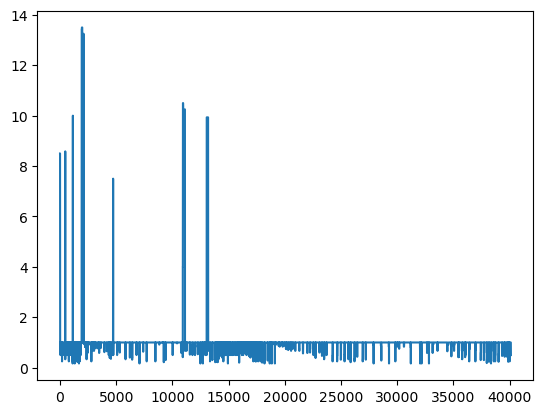

In [36]:
plt.plot(dn2["duration"].dt.total_seconds() / 3600)

In [37]:
# Add taxonomy information to retrieve species name similar to old data.
dnt = pd.merge(
    dn2,
    pd.read_csv(f"../data/taxonomy.csv")[["trektellen_species_id", "English name"]],
    how="left",
    left_on="speciesid",
    right_on="trektellen_species_id",
    indicator=True,
)

assert len(dn2) == len(dnt)


dnt[dnt["English name"].isna()]

dnt["species"] = dnt["English name"]
# Debug species
# print(df[["speciesname", "speciesid"]][df["species"].isna()].drop_duplicates())

In [38]:
dnt[dnt["species"].isna()]["speciesid"].unique()

array([], dtype=int64)

## Merge Old and Trektellen data


In [39]:
don = pd.concat(
    [
        dot[["species", "date", "count", "start", "end"]],
        dnt[["species", "date", "count", "start", "end"]],
    ],
    ignore_index=True,
).sort_values("start")

In [40]:
don.to_csv("../data/count/all_count_processed.csv", index=False)

---

## Visual

### Species

Filter list of species for raptor species (non-slash/spuh). The only issue would be Red/Black Kite, Buteo sp. and Buse ou Bondrée


In [41]:
tax = pd.read_csv("../data/taxonomy.csv")
tax = tax[
    tax["family"].isin(
        [
            "Accipitridae (Hawks, Eagles, and Kites)",
            "Pandionidae (Osprey)",
            "Falconidae (Falcons and Caracaras)",
        ]
    )
]
tax = tax[tax["category"] == "species"]
tax

,species,trektellen_species_id,match_to_ebird,species_code,taxon_concept_id,category,English name,scientific name,order,family
2,Autour des palombes,99.0,exact,norgos1,avibase-95DD1855,species,Eurasian Goshawk,Accipiter gentilis,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
3,Épervier d'Europe,100.0,exact,eurspa1,avibase-DB376A66,species,Eurasian Sparrowhawk,Accipiter nisus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
33,Aigle royal,107.0,exact,goleag,avibase-5F8E7CA8,species,Golden Eagle,Aquila chrysaetos,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
34,Aigle des steppes,NaN,exact,steeag1,avibase-A635F565,species,Steppe Eagle,Aquila nipalensis,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
43,Buse variable,101.0,exact,combuz1,avibase-3C0C325D,species,Common Buzzard,Buteo buteo,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
44,Buse pattue,NaN,exact,rolhaw,avibase-90B13ACF,species,Rough-legged Hawk,Buteo lagopus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
65,Circaète Jean-le-Blanc,94.0,exact,shteag1,avibase-8372FFBA,species,Short-toed Snake-Eagle,Circaetus gallicus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
66,Busard des roseaux,95.0,exact,wemhar1,avibase-E2A19474,species,Western Marsh Harrier,Circus aeruginosus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
67,Busard Saint-Martin,96.0,exact,norhar1,avibase-F558C7F9,species,Hen Harrier,Circus cyaneus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
68,Busard pâle,97.0,exact,palhar1,avibase-22647E26,species,Pallid Harrier,Circus macrourus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"


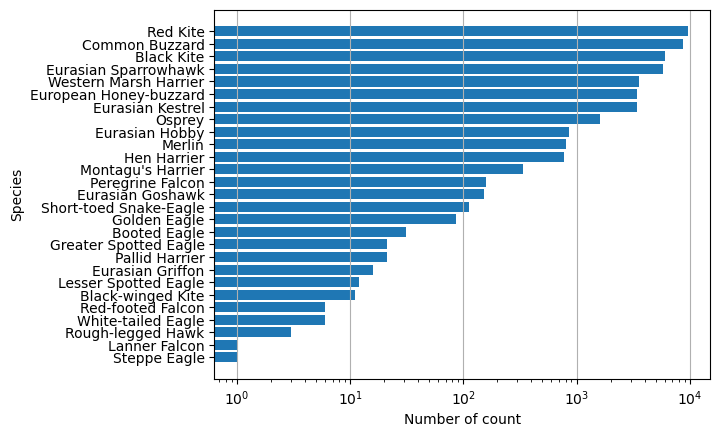

In [42]:
species_counts = don[don.species.isin(tax["English name"])].species.value_counts()
plt.barh(species_counts.index, species_counts.values, log=True)
plt.ylabel("Species")
plt.xlabel("Number of count")
plt.gca().invert_yaxis()
plt.gca().grid(axis="x")
plt.show()